In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepearing the data

In [44]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px




In [45]:
from scripts.data import Olist_Data
from scripts.utils import haversine_distance

In [46]:
orders = Olist_Data().get_data_from_csv()['orders'].copy()
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [47]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Some info is lacking for :
* order_approved_at
* order_delivered_carrier_date
* order_delivered_customer_date

160 orders have no approval datastamp

In [48]:
orders[orders['order_approved_at'].isna()].shape

(160, 8)

141 of them were canceled and just 14 delivered (maybe some bug during data collection)

In [49]:
# taking a closer look on rows with missing order approved datetime
orders[orders['order_approved_at'].isna()].groupby('order_status').count()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,,,,
canceled,141,141,141,0,0,0,141
created,5,5,5,0,0,0,5
delivered,14,14,14,0,14,14,14


1783 orders seem to not have any delivery to carrier

In [50]:
orders[orders['order_delivered_carrier_date'].isna()].shape

(1783, 8)

In [51]:
# taking a closer look on rows with missing order delivered to carrier datetime
orders[orders['order_delivered_carrier_date'].isna()].groupby('order_status').count()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,,,,
approved,2,2,2,2,0,0,2
canceled,550,550,550,409,0,0,550
created,5,5,5,0,0,0,5
delivered,2,2,2,2,0,1,2
invoiced,314,314,314,314,0,0,314
processing,301,301,301,301,0,0,301
unavailable,609,609,609,609,0,0,609


Almost 3000 orders were not delivered

In [52]:
orders[orders['order_delivered_customer_date'].isna()].shape

(2965, 8)

In [53]:
# taking a closer look on rows with missing  datetime of delivery to customer
orders[orders['order_delivered_customer_date'].isna()].groupby('order_status').count()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,,,,
approved,2,2,2,2,0,0,2
canceled,619,619,619,478,69,0,619
created,5,5,5,0,0,0,5
delivered,8,8,8,8,7,0,8
invoiced,314,314,314,314,0,0,314
processing,301,301,301,301,0,0,301
shipped,1107,1107,1107,1107,1107,0,1107
unavailable,609,609,609,609,0,0,609


There are definetely problems with data records cause some `order_status` indicates `delivered` while `order_delivered_customer_date` has NaN value

In [54]:
orders[(orders['order_delivered_customer_date'].isna()) & (orders['order_status'] == 'delivered') ]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaN,2017-12-18 00:00:00
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaN,2018-07-16 00:00:00
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaN,2018-07-24 00:00:00
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaN,NaN,2017-06-23 00:00:00
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaN,2018-06-26 00:00:00
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaN,2018-07-19 00:00:00


Let's check the number of orders per `order_status`

In [55]:
orders.groupby('order_status').count().sort_values(by='order_id', ascending=False)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,,,,
delivered,96478,96478,96478,96464,96476,96470,96478
shipped,1107,1107,1107,1107,1107,0,1107
canceled,625,625,625,484,75,6,625
unavailable,609,609,609,609,0,0,609
invoiced,314,314,314,314,0,0,314
processing,301,301,301,301,0,0,301
created,5,5,5,0,0,0,5
approved,2,2,2,2,0,0,2


In [56]:
# for now we will just simplify our geolocation record by deleting rows that have
# identical zip codes but different locations

geo = Olist_Data().get_data_from_csv()['geolocation']
geo = geo.drop_duplicates(subset='geolocation_zip_code_prefix', keep='first')
geo

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
...,...,...,...,...,...
999774,99955,-28.107588,-52.144019,vila langaro,RS
999780,99970,-28.345143,-51.876926,ciriaco,RS
999786,99910,-27.863500,-52.084760,floriano peixoto,RS
999803,99920,-27.858716,-52.300403,erebango,RS


In [57]:
sellers = Olist_Data().get_data_from_csv()['sellers'].copy()
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [58]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [59]:
customers = Olist_Data().get_data_from_csv()['customers'].copy()
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [60]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [61]:
order_items = Olist_Data().get_data_from_csv()['order_items'].copy()
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [62]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [63]:
products = Olist_Data().get_data_from_csv()['products'].copy()
products


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


For now let's try to merge it into one df.

In [64]:
df_order_customer = orders.merge(customers[['customer_id', 'customer_zip_code_prefix']], on='customer_id')
df_order_customer.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3149
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,47813
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,75265
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,59296
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,9195


In [65]:
df_seller_ord_item = order_items.merge(sellers[['seller_id', 'seller_zip_code_prefix']], on='seller_id')
df_seller_ord_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,27277
1,0188777fe321843a18be24a6e9aa1e53,1,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.9,9.94,27277
2,0191bbb5166d4b9a68df11797d5acfa9,1,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.9,20.17,27277
3,03054d8a8eefc2981cfad06f58e27979,1,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,2017-10-09 10:35:11,58.9,15.16,27277
4,0c325ea6925de749e1420be0cf43587c,1,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,2017-07-06 15:43:50,139.9,16.74,27277


In [66]:
df = df_seller_ord_item.merge(df_order_customer, on='order_id', how='left')
df.drop(['order_item_id'], axis=1, inplace=True)


In [67]:
df

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,28013
1,0188777fe321843a18be24a6e9aa1e53,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.90,9.94,27277,dc573d2a61a467e5e2826c1729691859,delivered,2017-07-23 16:13:37,2017-07-25 14:35:11,2017-07-27 18:45:50,2017-07-28 16:18:00,2017-08-08 00:00:00,25240
2,0191bbb5166d4b9a68df11797d5acfa9,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.90,20.17,27277,62b59a64eb786a96516229b7f3612c72,delivered,2017-08-10 12:17:35,2017-08-10 12:30:15,2017-08-15 19:26:45,2017-08-24 18:15:16,2017-09-08 00:00:00,93010
3,03054d8a8eefc2981cfad06f58e27979,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,2017-10-09 10:35:11,58.90,15.16,27277,9bd2f246e81c19f65c539ce426288ef5,delivered,2017-10-02 10:25:22,2017-10-03 10:35:11,2017-10-09 17:57:50,2017-10-19 21:03:49,2017-10-25 00:00:00,3560
4,0c325ea6925de749e1420be0cf43587c,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,2017-07-06 15:43:50,139.90,16.74,27277,e03505278b34146e87c0b4eb41e4f082,delivered,2017-07-01 15:27:23,2017-07-01 15:43:50,2017-07-05 12:00:33,2017-07-10 17:17:21,2017-07-25 00:00:00,18540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fdfeec75aa07c1d2a88b17b8fbfc7b8f,11059273f4bc1a293777e98c89807c62,dbc51f5e45d654ecc16cb68e6817ecea,2017-03-01 22:42:22,199.99,18.14,14402,8fbd29638b8ddd97d012473abf1f7752,delivered,2017-02-24 22:28:55,2017-02-24 22:42:22,2017-03-04 11:58:57,2017-03-14 16:17:59,2017-03-21 00:00:00,23812
112646,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.00,16.21,82620,94203a446c1b46b5ac95b0aaf7221804,delivered,2017-08-11 10:15:22,2017-08-12 02:55:27,2017-08-14 22:03:19,2017-08-17 17:47:55,2017-09-04 00:00:00,13485
112647,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13,6729.00,193.21,86026,f48d464a0baaea338cb25f816991ab1f,delivered,2018-07-25 18:10:17,2018-07-27 04:05:13,2018-08-03 14:42:00,2018-08-15 14:57:50,2018-08-10 00:00:00,29066
112648,ff701a7c869ad21de22a6994237c8a00,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,3124,8f6d16c31abb30b7b4650272cb0014a3,delivered,2018-04-12 19:47:40,2018-04-12 20:10:33,2018-04-18 00:41:29,2018-04-20 17:48:39,2018-04-30 00:00:00,12280


In [68]:
df_all = df.merge(geo, left_on='seller_zip_code_prefix', 
                        right_on='geolocation_zip_code_prefix', 
                        how='left')
df_all = df_all.merge(geo, left_on = "customer_zip_code_prefix", 
                            right_on = "geolocation_zip_code_prefix", 
                            how = "left",
                            suffixes = ("_seller", "_customer"))

df_all

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,...,geolocation_zip_code_prefix_seller,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_seller,geolocation_state_seller,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,28013.0,-21.758076,-41.312633,campos dos goytacazes,RJ
1,0188777fe321843a18be24a6e9aa1e53,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.90,9.94,27277,dc573d2a61a467e5e2826c1729691859,delivered,2017-07-23 16:13:37,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,25240.0,-22.651763,-43.299104,duque de caxias,RJ
2,0191bbb5166d4b9a68df11797d5acfa9,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.90,20.17,27277,62b59a64eb786a96516229b7f3612c72,delivered,2017-08-10 12:17:35,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,93010.0,-29.764677,-51.152386,sao leopoldo,RS
3,03054d8a8eefc2981cfad06f58e27979,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,2017-10-09 10:35:11,58.90,15.16,27277,9bd2f246e81c19f65c539ce426288ef5,delivered,2017-10-02 10:25:22,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,3560.0,-23.551047,-46.494672,sao paulo,SP
4,0c325ea6925de749e1420be0cf43587c,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,2017-07-06 15:43:50,139.90,16.74,27277,e03505278b34146e87c0b4eb41e4f082,delivered,2017-07-01 15:27:23,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,18540.0,-23.213643,-47.522045,porto feliz,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fdfeec75aa07c1d2a88b17b8fbfc7b8f,11059273f4bc1a293777e98c89807c62,dbc51f5e45d654ecc16cb68e6817ecea,2017-03-01 22:42:22,199.99,18.14,14402,8fbd29638b8ddd97d012473abf1f7752,delivered,2017-02-24 22:28:55,...,14402.0,-20.525122,-47.359864,franca,SP,23812.0,-22.872199,-43.772043,itaguai,RJ
112646,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.00,16.21,82620,94203a446c1b46b5ac95b0aaf7221804,delivered,2017-08-11 10:15:22,...,82620.0,-25.379062,-49.227004,curitiba,PR,13485.0,-22.546108,-47.383618,limeira,SP
112647,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13,6729.00,193.21,86026,f48d464a0baaea338cb25f816991ab1f,delivered,2018-07-25 18:10:17,...,86026.0,-23.306545,-51.153471,londrina,PR,29066.0,-20.274743,-40.284131,vitoria,ES
112648,ff701a7c869ad21de22a6994237c8a00,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,3124,8f6d16c31abb30b7b4650272cb0014a3,delivered,2018-04-12 19:47:40,...,3124.0,-23.567864,-46.592424,sao paulo,SP,12280.0,-23.098284,-45.703308,cacapava,SP


In [69]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   order_id                              112650 non-null  object 
 1   product_id                            112650 non-null  object 
 2   seller_id                             112650 non-null  object 
 3   shipping_limit_date                   112650 non-null  object 
 4   price                                 112650 non-null  float64
 5   freight_value                         112650 non-null  float64
 6   seller_zip_code_prefix                112650 non-null  int64  
 7   customer_id                           112650 non-null  object 
 8   order_status                          112650 non-null  object 
 9   order_purchase_timestamp              112650 non-null  object 
 10  order_approved_at                     112635 non-null  object 
 11  

We have 302 orders with no customer geolocation data

In [70]:
len(df_all[df_all.geolocation_city_customer.isnull()])

302

We have 253 orders with no seller geolocation data

In [71]:
len(df_all[df_all.geolocation_city_seller.isnull()])

253

Just one order has no geo info about seller and customer

In [72]:
len(df_all[df_all.geolocation_city_seller.isnull() & df_all.geolocation_city_customer.isnull()])

1

As we know one order can have multiple products.

In [73]:
order_count = df_all.groupby(by="order_id").nunique()
order_count

,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,order_approved_at,...,geolocation_zip_code_prefix_seller,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_seller,geolocation_state_seller,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
00018f77f2f0320c557190d7a144bdd3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
000229ec398224ef6ca0657da4fc703e,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
00024acbcdf0a6daa1e931b038114c75,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
00042b26cf59d7ce69dfabb4e55b4fd9,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
fffcd46ef2263f404302a634eb57f7eb,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
fffce4705a9662cd70adb13d4a31832d,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


13 984 orders contain multiple products/multiple sellers involved

In [74]:
order_count.product_id.unique()

array([1, 2, 4, 3, 5, 6, 7, 8])

In fact we can see following distribution and the majority made one article purchase

In [75]:
order_count.groupby(by="product_id").count()

,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,geolocation_zip_code_prefix_seller,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_seller,geolocation_state_seller,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer
product_id,,,,,,,,,,,,,,,,,,,,,
1,95430,95430,95430,95430,95430,95430,95430,95430,95430,95430,...,95430,95430,95430,95430,95430,95430,95430,95430,95430,95430
2,2846,2846,2846,2846,2846,2846,2846,2846,2846,2846,...,2846,2846,2846,2846,2846,2846,2846,2846,2846,2846
3,298,298,298,298,298,298,298,298,298,298,...,298,298,298,298,298,298,298,298,298,298
4,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
5,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
6,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
7,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


For now, for our further modelling we will exclude the possibility that 'multiple sellers' influence the delivery time.

In [76]:
# deleting orders that have multiple sellers
unique_orders = pd.Series(order_count[order_count['seller_id'] == 1].index)
filtered_orders = df_all.merge(unique_orders, how = 'inner')

filtered_orders

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,...,geolocation_zip_code_prefix_seller,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_seller,geolocation_state_seller,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,28013.0,-21.758076,-41.312633,campos dos goytacazes,RJ
1,0188777fe321843a18be24a6e9aa1e53,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.90,9.94,27277,dc573d2a61a467e5e2826c1729691859,delivered,2017-07-23 16:13:37,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,25240.0,-22.651763,-43.299104,duque de caxias,RJ
2,0191bbb5166d4b9a68df11797d5acfa9,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.90,20.17,27277,62b59a64eb786a96516229b7f3612c72,delivered,2017-08-10 12:17:35,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,93010.0,-29.764677,-51.152386,sao leopoldo,RS
3,03054d8a8eefc2981cfad06f58e27979,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,2017-10-09 10:35:11,58.90,15.16,27277,9bd2f246e81c19f65c539ce426288ef5,delivered,2017-10-02 10:25:22,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,3560.0,-23.551047,-46.494672,sao paulo,SP
4,0c325ea6925de749e1420be0cf43587c,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,2017-07-06 15:43:50,139.90,16.74,27277,e03505278b34146e87c0b4eb41e4f082,delivered,2017-07-01 15:27:23,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,18540.0,-23.213643,-47.522045,porto feliz,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109542,fdfeec75aa07c1d2a88b17b8fbfc7b8f,11059273f4bc1a293777e98c89807c62,dbc51f5e45d654ecc16cb68e6817ecea,2017-03-01 22:42:22,199.99,18.14,14402,8fbd29638b8ddd97d012473abf1f7752,delivered,2017-02-24 22:28:55,...,14402.0,-20.525122,-47.359864,franca,SP,23812.0,-22.872199,-43.772043,itaguai,RJ
109543,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.00,16.21,82620,94203a446c1b46b5ac95b0aaf7221804,delivered,2017-08-11 10:15:22,...,82620.0,-25.379062,-49.227004,curitiba,PR,13485.0,-22.546108,-47.383618,limeira,SP
109544,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13,6729.00,193.21,86026,f48d464a0baaea338cb25f816991ab1f,delivered,2018-07-25 18:10:17,...,86026.0,-23.306545,-51.153471,londrina,PR,29066.0,-20.274743,-40.284131,vitoria,ES
109545,ff701a7c869ad21de22a6994237c8a00,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,3124,8f6d16c31abb30b7b4650272cb0014a3,delivered,2018-04-12 19:47:40,...,3124.0,-23.567864,-46.592424,sao paulo,SP,12280.0,-23.098284,-45.703308,cacapava,SP


In [77]:
#deleting col with data approval which has most of NaN values
final_df = filtered_orders.drop(columns = ["order_approved_at"])
final_df

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,...,geolocation_zip_code_prefix_seller,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_seller,geolocation_state_seller,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,28013.0,-21.758076,-41.312633,campos dos goytacazes,RJ
1,0188777fe321843a18be24a6e9aa1e53,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.90,9.94,27277,dc573d2a61a467e5e2826c1729691859,delivered,2017-07-23 16:13:37,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,25240.0,-22.651763,-43.299104,duque de caxias,RJ
2,0191bbb5166d4b9a68df11797d5acfa9,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.90,20.17,27277,62b59a64eb786a96516229b7f3612c72,delivered,2017-08-10 12:17:35,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,93010.0,-29.764677,-51.152386,sao leopoldo,RS
3,03054d8a8eefc2981cfad06f58e27979,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,2017-10-09 10:35:11,58.90,15.16,27277,9bd2f246e81c19f65c539ce426288ef5,delivered,2017-10-02 10:25:22,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,3560.0,-23.551047,-46.494672,sao paulo,SP
4,0c325ea6925de749e1420be0cf43587c,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,2017-07-06 15:43:50,139.90,16.74,27277,e03505278b34146e87c0b4eb41e4f082,delivered,2017-07-01 15:27:23,...,27277.0,-22.498183,-44.123614,volta redonda,RJ,18540.0,-23.213643,-47.522045,porto feliz,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109542,fdfeec75aa07c1d2a88b17b8fbfc7b8f,11059273f4bc1a293777e98c89807c62,dbc51f5e45d654ecc16cb68e6817ecea,2017-03-01 22:42:22,199.99,18.14,14402,8fbd29638b8ddd97d012473abf1f7752,delivered,2017-02-24 22:28:55,...,14402.0,-20.525122,-47.359864,franca,SP,23812.0,-22.872199,-43.772043,itaguai,RJ
109543,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.00,16.21,82620,94203a446c1b46b5ac95b0aaf7221804,delivered,2017-08-11 10:15:22,...,82620.0,-25.379062,-49.227004,curitiba,PR,13485.0,-22.546108,-47.383618,limeira,SP
109544,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13,6729.00,193.21,86026,f48d464a0baaea338cb25f816991ab1f,delivered,2018-07-25 18:10:17,...,86026.0,-23.306545,-51.153471,londrina,PR,29066.0,-20.274743,-40.284131,vitoria,ES
109545,ff701a7c869ad21de22a6994237c8a00,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,3124,8f6d16c31abb30b7b4650272cb0014a3,delivered,2018-04-12 19:47:40,...,3124.0,-23.567864,-46.592424,sao paulo,SP,12280.0,-23.098284,-45.703308,cacapava,SP


Using Haversine distance we can create an additional column with the distance btwn seller and customer.

In [78]:
final_df["distance"] = haversine_distance(final_df, 
                                    start_lat="geolocation_lat_seller", start_lon="geolocation_lng_seller",
                                    end_lat="geolocation_lat_customer", end_lon="geolocation_lng_customer")

We will require package size as well

In [79]:
prod_m = order_items[['order_id', 'product_id']].merge(products[['product_id', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']],
                                        on = "product_id",
                                        how = "outer")

prod_m.loc[:, "product_size_cm3"] = prod_m['product_length_cm'] * prod_m['product_width_cm'] * prod_m['product_height_cm']

orders_size_weight = prod_m.groupby("order_id", as_index = False).sum()[['order_id','product_size_cm3', 'product_weight_g']]


In [80]:
final_df = final_df.merge(orders_size_weight,
                    on = 'order_id',
                    how = 'left')
final_df.head()

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,...,geolocation_city_seller,geolocation_state_seller,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer,distance,product_size_cm3,product_weight_g
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,27277,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,volta redonda,RJ,28013.0,-21.758076,-41.312633,campos dos goytacazes,RJ,301.005664,3528.0,650.0
1,0188777fe321843a18be24a6e9aa1e53,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.9,9.94,27277,dc573d2a61a467e5e2826c1729691859,delivered,2017-07-23 16:13:37,...,volta redonda,RJ,25240.0,-22.651763,-43.299104,duque de caxias,RJ,86.361609,3780.0,530.0
2,0191bbb5166d4b9a68df11797d5acfa9,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.9,20.17,27277,62b59a64eb786a96516229b7f3612c72,delivered,2017-08-10 12:17:35,...,volta redonda,RJ,93010.0,-29.764677,-51.152386,sao leopoldo,RS,1069.557370,20250.0,2275.0
3,03054d8a8eefc2981cfad06f58e27979,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,2017-10-09 10:35:11,58.9,15.16,27277,9bd2f246e81c19f65c539ce426288ef5,delivered,2017-10-02 10:25:22,...,volta redonda,RJ,3560.0,-23.551047,-46.494672,sao paulo,SP,269.406023,2750.0,400.0
4,0c325ea6925de749e1420be0cf43587c,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,2017-07-06 15:43:50,139.9,16.74,27277,e03505278b34146e87c0b4eb41e4f082,delivered,2017-07-01 15:27:23,...,volta redonda,RJ,18540.0,-23.213643,-47.522045,porto feliz,SP,357.179585,8892.0,600.0


Lets calculate the time needed for a product to get to the customer from the moment it was sent.

In [81]:
# pick up exclusively time cols
time_columns = ['order_purchase_timestamp',
                 'order_delivered_customer_date',
                 'order_estimated_delivery_date']

# convert columns to time format
for column in time_columns:
    final_df[column] = pd.to_datetime(final_df[column])

In [82]:
final_df['wait_time'] = (final_df['order_delivered_customer_date'] - final_df['order_purchase_timestamp']).dt.days

In [83]:
final_df

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,...,geolocation_state_seller,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer,distance,product_size_cm3,product_weight_g,wait_time
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,RJ,28013.0,-21.758076,-41.312633,campos dos goytacazes,RJ,301.005664,3528.0,650.0,7.0
1,0188777fe321843a18be24a6e9aa1e53,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.90,9.94,27277,dc573d2a61a467e5e2826c1729691859,delivered,2017-07-23 16:13:37,...,RJ,25240.0,-22.651763,-43.299104,duque de caxias,RJ,86.361609,3780.0,530.0,5.0
2,0191bbb5166d4b9a68df11797d5acfa9,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.90,20.17,27277,62b59a64eb786a96516229b7f3612c72,delivered,2017-08-10 12:17:35,...,RJ,93010.0,-29.764677,-51.152386,sao leopoldo,RS,1069.557370,20250.0,2275.0,14.0
3,03054d8a8eefc2981cfad06f58e27979,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,2017-10-09 10:35:11,58.90,15.16,27277,9bd2f246e81c19f65c539ce426288ef5,delivered,2017-10-02 10:25:22,...,RJ,3560.0,-23.551047,-46.494672,sao paulo,SP,269.406023,2750.0,400.0,17.0
4,0c325ea6925de749e1420be0cf43587c,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,2017-07-06 15:43:50,139.90,16.74,27277,e03505278b34146e87c0b4eb41e4f082,delivered,2017-07-01 15:27:23,...,RJ,18540.0,-23.213643,-47.522045,porto feliz,SP,357.179585,8892.0,600.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109542,fdfeec75aa07c1d2a88b17b8fbfc7b8f,11059273f4bc1a293777e98c89807c62,dbc51f5e45d654ecc16cb68e6817ecea,2017-03-01 22:42:22,199.99,18.14,14402,8fbd29638b8ddd97d012473abf1f7752,delivered,2017-02-24 22:28:55,...,SP,23812.0,-22.872199,-43.772043,itaguai,RJ,453.299289,5610.0,1050.0,17.0
109543,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.00,16.21,82620,94203a446c1b46b5ac95b0aaf7221804,delivered,2017-08-11 10:15:22,...,PR,13485.0,-22.546108,-47.383618,limeira,SP,366.475121,3825.0,500.0,6.0
109544,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13,6729.00,193.21,86026,f48d464a0baaea338cb25f816991ab1f,delivered,2018-07-25 18:10:17,...,PR,29066.0,-20.274743,-40.284131,vitoria,ES,1171.388586,45684.0,5660.0,20.0
109545,ff701a7c869ad21de22a6994237c8a00,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,3124,8f6d16c31abb30b7b4650272cb0014a3,delivered,2018-04-12 19:47:40,...,SP,12280.0,-23.098284,-45.703308,cacapava,SP,104.724773,27436.0,4000.0,7.0


In [84]:
final_df[(final_df['product_weight_g'] <= 0) | (final_df['product_size_cm3'] <= 0)]

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,...,geolocation_state_seller,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer,distance,product_size_cm3,product_weight_g,wait_time
33649,101157d4fae1c9fb74a00a5dee265c25,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-11 08:02:26,29.0,14.52,12327,f72b2f8d9295ef93fd40a4c49f67a42b,delivered,2017-04-03 07:54:34,...,SP,22631.0,-23.004309,-43.324508,rio de janeiro,RJ,272.928962,0.0,0.0,10.0
33653,1521c6bb7b1028154c8c67cf80fa809f,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-07 10:10:16,29.0,16.05,12327,ca29b2bf57243228e98eab2dab805ae9,delivered,2017-04-02 10:00:43,...,SP,73105.0,-15.654091,-47.860892,brasilia,DF,872.632238,0.0,0.0,16.0
33725,415cfaaaa8cea49f934470548797fed1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-07 10:35:19,29.0,14.52,12327,a8dff6357fea30071032ff2091d16430,delivered,2017-04-02 10:25:38,...,SP,86709.0,-23.406937,-51.459611,arapongas,PR,560.017401,0.0,0.0,26.0
33726,415cfaaaa8cea49f934470548797fed1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-07 10:35:19,29.0,14.52,12327,a8dff6357fea30071032ff2091d16430,delivered,2017-04-02 10:25:38,...,SP,86709.0,-23.406937,-51.459611,arapongas,PR,560.017401,0.0,0.0,26.0
33760,595316a07cd3dea9db7adfcc7e247ae7,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-08-18 04:26:04,39.0,9.27,12327,696e8f940eeee6b009d1539b59e47366,delivered,2017-08-09 23:50:08,...,SP,13190.0,-22.950010,-47.305839,monte mor,SP,141.508930,0.0,0.0,7.0
33803,6e150190fbe04c642a9cf0b80d83ee16,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-06-30 16:45:14,39.0,16.79,12327,135a42a465867ff932f1222f71a3efb2,delivered,2017-06-24 16:33:35,...,SP,78600.0,-15.876364,-52.263206,barra do garças,MT,1055.539044,0.0,0.0,13.0
33805,6f497c40431d5fb0cfbd6c943dd29215,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-11 05:55:32,29.0,10.96,12327,5beb36d1757aa17a044222a7d79b9820,delivered,2017-04-01 14:26:15,...,SP,12703.0,-22.586731,-44.976029,cruzeiro,SP,129.300302,0.0,0.0,5.0
33893,a2456e7f02197951664897a94c87242d,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-06 11:50:09,29.0,24.84,12327,7317f41f2cf650174af819cdb68284f0,delivered,2017-03-30 11:39:20,...,SP,64228.0,-3.417970,-41.897130,caxingo,PI,2253.659370,0.0,0.0,35.0
33902,a7a43f469c0d7bdb0a23a82db125aefa,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-08-28 13:15:11,39.0,15.10,12327,d7c95dc1ece116c14188092ead3d0951,delivered,2017-08-21 13:00:05,...,SP,30421.0,-19.939689,-43.975338,belo horizonte,MG,426.809961,0.0,0.0,7.0
33934,bbfc7badbed2f1828e22b6d629201bd4,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-07-18 04:04:10,39.0,11.85,12327,f25f442c0ff3a9401eed8ed3a686f362,delivered,2017-07-09 10:35:08,...,SP,18052.0,-23.539013,-47.491042,sorocaba,SP,157.007035,0.0,0.0,9.0


In [85]:
# delete all the rows where the size or weight of the product are <=  0
final_df.drop(final_df.index[(final_df['product_weight_g'] <= 0) | (final_df['product_size_cm3'] <= 0)], 
            inplace=True)

Are there deliveries with no wait time? 

But is it really possible to deliver on the same day with such distances btwn customer and the seller? Having no knowledge if the company provides some special system of deliveries for some specific clients/orders we will delete those orders.

In [92]:
final_df[((final_df['wait_time'] == 0) | (final_df['wait_time'].isnull()))]

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,customer_id,order_status,order_purchase_timestamp,...,geolocation_state_seller,geolocation_zip_code_prefix_customer,geolocation_lat_customer,geolocation_lng_customer,geolocation_city_customer,geolocation_state_customer,distance,product_size_cm3,product_weight_g,wait_time
9,1856dd06ccd053bf3456e3d5bf73f2e3,54e5939fcd9ae70ad0f59f612d6d29bd,48436dade18ac8b2bce089ec2a041202,2017-10-05 20:23:08,42.9,16.11,27277,cc109454691b793edeaeed419bcbf617,invoiced,2017-09-30 20:12:05,...,RJ,37545.0,-22.354227,-45.773754,cachoeira de minas,MG,170.363108,4050.0,550.0,NaN
73,8e78a66489b3861f846342d4b158c8f4,2423252b2432f1803e4f29e0974c6cf7,48436dade18ac8b2bce089ec2a041202,2017-10-09 19:14:27,139.9,18.23,27277,ca5be60ca176490157a53b88dfc30c98,invoiced,2017-10-03 19:04:04,...,RJ,8257.0,-23.554070,-46.429846,sao paulo,SP,263.594356,20160.0,1167.0,NaN
97,afef48d3c8a0b1b7c9b7f8f922fb5674,31945c8811d04df20bf86224210b4084,48436dade18ac8b2bce089ec2a041202,2017-11-17 16:50:47,134.9,18.51,27277,65f09de0b77ca07963fde8601c6be1fb,invoiced,2017-11-10 16:27:32,...,RJ,96600.0,-31.387797,-52.683644,cangucu,RS,1301.626908,12240.0,900.0,NaN
113,bf3b217e5505e5e9d746120dbb93b562,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-30 07:25:13,132.9,18.18,27277,0669f5398348b7260f7f14411736e78f,shipped,2017-08-24 07:15:30,...,RJ,6874.0,-23.759561,-46.843837,itapecerica da serra,SP,311.512832,20250.0,2275.0,NaN
154,088683f795a3d30bfd61152c4fabdfb2,86742dc5c815f1c8c04c6e323e3c1865,dd7ddc04e1b6c2c614352b383efe2d36,2017-07-20 02:25:54,29.9,16.92,3471,58d89fd1f863819ff9b040734f7bd7c6,shipped,2017-07-13 10:02:47,...,SP,78138.0,-15.654311,-56.158523,varzea grande,MT,1338.315180,41664.0,6950.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109532,fc3078fa5d882e59237a658341f57738,b5d652cabeb01249ad1cf910eef3230b,b57e8460909fa137df7951b4a3b5ea84,2017-03-08 08:05:18,99.0,42.07,90640,66beadbcff140118a939ede891f05d18,processing,2017-03-02 07:53:29,...,RS,4288.0,-23.610109,-46.612243,sao paulo,SP,849.670493,127764.0,4000.0,NaN
109533,fc32248629afaea92d59f7086de552d3,9754ea6652dc3e06be088797f85f4ee5,7a188843479798ca813108fa7b959286,2017-11-28 02:46:53,49.9,8.72,4276,0ea67385838ca5b2819a5422c7004a40,processing,2017-11-20 11:45:27,...,SP,9015.0,-23.665703,-46.518082,santo andre,SP,11.910456,21600.0,1200.0,NaN
109534,fc32248629afaea92d59f7086de552d3,9754ea6652dc3e06be088797f85f4ee5,7a188843479798ca813108fa7b959286,2017-11-28 02:46:53,49.9,8.72,4276,0ea67385838ca5b2819a5422c7004a40,processing,2017-11-20 11:45:27,...,SP,9015.0,-23.665703,-46.518082,santo andre,SP,11.910456,21600.0,1200.0,NaN
109535,fc32248629afaea92d59f7086de552d3,9754ea6652dc3e06be088797f85f4ee5,7a188843479798ca813108fa7b959286,2017-11-28 02:46:53,49.9,8.72,4276,0ea67385838ca5b2819a5422c7004a40,processing,2017-11-20 11:45:27,...,SP,9015.0,-23.665703,-46.518082,santo andre,SP,11.910456,21600.0,1200.0,NaN


In [93]:
#deleting all rows with NaN values
final_df.dropna(how='any',inplace=True)

In [95]:
final_df[final_df['wait_time'] == 0]
# delete all the rows where the size or weight of the product are <=  0
final_df.drop(final_df.index[(final_df['wait_time'] == 0)], inplace=True)

In [96]:
final_df.columns

Index(['order_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'seller_zip_code_prefix', 'customer_id',
       'order_status', 'order_purchase_timestamp',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_zip_code_prefix',
       'geolocation_zip_code_prefix_seller', 'geolocation_lat_seller',
       'geolocation_lng_seller', 'geolocation_city_seller',
       'geolocation_state_seller', 'geolocation_zip_code_prefix_customer',
       'geolocation_lat_customer', 'geolocation_lng_customer',
       'geolocation_city_customer', 'geolocation_state_customer', 'distance',
       'product_size_cm3', 'product_weight_g', 'wait_time'],
      dtype='object')

In [97]:
final_df.shape

(106534, 28)

There are no buggy transactions with weird geolocations

In [99]:
final_df[(final_df.geolocation_lat_seller == 0) | (final_df.geolocation_lng_seller == 0) |
        (final_df.geolocation_lat_customer == 0) | (final_df.geolocation_lng_customer == 0)].shape

(0, 28)

In [101]:
col_list = ['order_id', 'order_purchase_timestamp',
            'order_delivered_customer_date', 
            'geolocation_state_customer', 'geolocation_state_seller',
            'distance',
            'product_size_cm3', 'product_weight_g',
            'wait_time',
            'order_estimated_delivery_date']

In [105]:
# keeping just the selectedlist of cols
df = final_df.loc[:, col_list]
df.loc[:,'count'] = 1


In [106]:
df.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,geolocation_state_customer,geolocation_state_seller,distance,product_size_cm3,product_weight_g,wait_time,order_estimated_delivery_date,count
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,RJ,RJ,301.005664,3528.0,650.0,7.0,2017-09-29,1
1,0188777fe321843a18be24a6e9aa1e53,2017-07-23 16:13:37,2017-07-28 16:18:00,RJ,RJ,86.361609,3780.0,530.0,5.0,2017-08-08,1
2,0191bbb5166d4b9a68df11797d5acfa9,2017-08-10 12:17:35,2017-08-24 18:15:16,RS,RJ,1069.557370,20250.0,2275.0,14.0,2017-09-08,1
3,03054d8a8eefc2981cfad06f58e27979,2017-10-02 10:25:22,2017-10-19 21:03:49,SP,RJ,269.406023,2750.0,400.0,17.0,2017-10-25,1
4,0c325ea6925de749e1420be0cf43587c,2017-07-01 15:27:23,2017-07-10 17:17:21,SP,RJ,357.179585,8892.0,600.0,9.0,2017-07-25,1


Because we have quite a big dataset we might need to make its size more optimal. We will downcast numerical columns

In [107]:
def compress(df, **kwargs):
    """
    Reduces size of dataframe by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')
    
    in_size = df.memory_usage(index=True).sum()
    for t in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=t))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)
            
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100
    
    print("optimized size by {} %".format(round(ratio,2)))
    print("new dataframe size: ", round(out_size / 1024**2,2), " MB")
    return df

The compression wasn't very important for this dataset. We managed to reduce its size by 24%

In [108]:
df = compress(df, verbose=True)
df.head(1)

old dataframe size:  9.75 MB
optimized size by 24.0 %
new dataframe size:  7.42  MB


,order_id,order_purchase_timestamp,order_delivered_customer_date,geolocation_state_customer,geolocation_state_seller,distance,product_size_cm3,product_weight_g,wait_time,order_estimated_delivery_date,count
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,RJ,RJ,301.005676,3528.0,650.0,7.0,2017-09-29,1


In [109]:
df.dtypes

order_id                                 object
order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date    datetime64[ns]
geolocation_state_customer               object
geolocation_state_seller                 object
distance                                float32
product_size_cm3                        float32
product_weight_g                        float32
wait_time                               float32
order_estimated_delivery_date    datetime64[ns]
count                                      int8
dtype: object

In [110]:
df.shape

(106534, 11)

# EDA

Lets take a closer look on our data

In [111]:
df.drop(columns=df.select_dtypes('datetime64').columns).describe()

,distance,product_size_cm3,product_weight_g,wait_time,count
count,106534.000000,1.065340e+05,106534.000000,106534.000000,106534.0
mean,597.873291,2.090158e+04,2839.892578,12.099189,1.0
std,592.816406,4.360510e+04,6705.481445,9.518680,0.0
min,0.000000,1.680000e+02,2.000000,1.000000,1.0
25%,182.331509,3.136000e+03,335.000000,6.000000,1.0
50%,432.301422,8.000000e+03,820.000000,10.000000,1.0
75%,793.132324,2.197800e+04,2400.000000,15.000000,1.0
max,8736.947266,1.476000e+06,184400.000000,209.000000,1.0


Text(0.5, 1.0, 'Histogram')

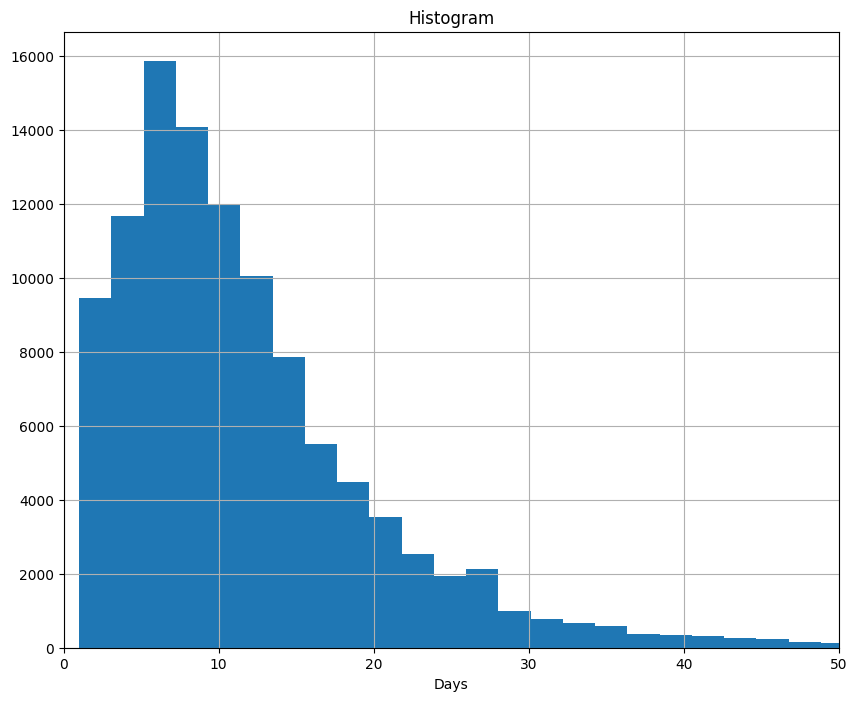

In [112]:
df.wait_time.hist(bins=100, figsize=(10,8))
plt.xlabel('Days')
plt.xlim(0, 50)
plt.title('Histogram')

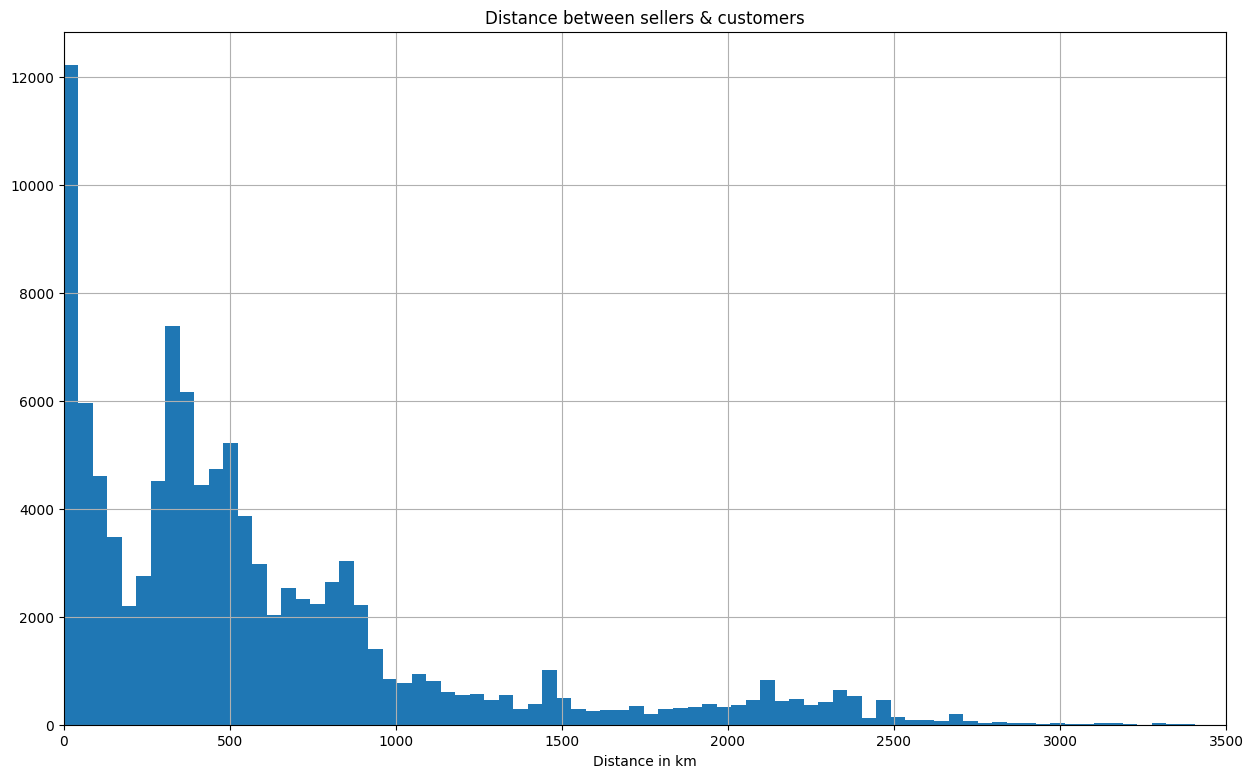

In [113]:
# distance
df.distance.hist(bins=200, figsize=(15,9))
plt.xlabel('Distance in km')
plt.xlim(0, 3500)
plt.title('Distance between sellers & customers');

## Delivery & Purchase per day

In [116]:
#how many orders were delivered on a certain day
daily_delivery = pd.DataFrame(df['order_delivered_customer_date'].groupby([df['order_delivered_customer_date'].dt.date]).count())
#how many orders were completed on a certain day
daily_order = pd.DataFrame(df['order_purchase_timestamp'].groupby([df['order_purchase_timestamp'].dt.date]).count())


/Users/oksanamishchenko/.pyenv/versions/3.8.12/envs/olist_ecommerce/lib/python3.8/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/oksanamishchenko/.pyenv/versions/3.8.12/envs/olist_ecommerce/lib/python3.8/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/Users/oksanamishchenko/.pyenv/versions/3.8.12/envs/olist_ecommerce/lib/python3.8/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


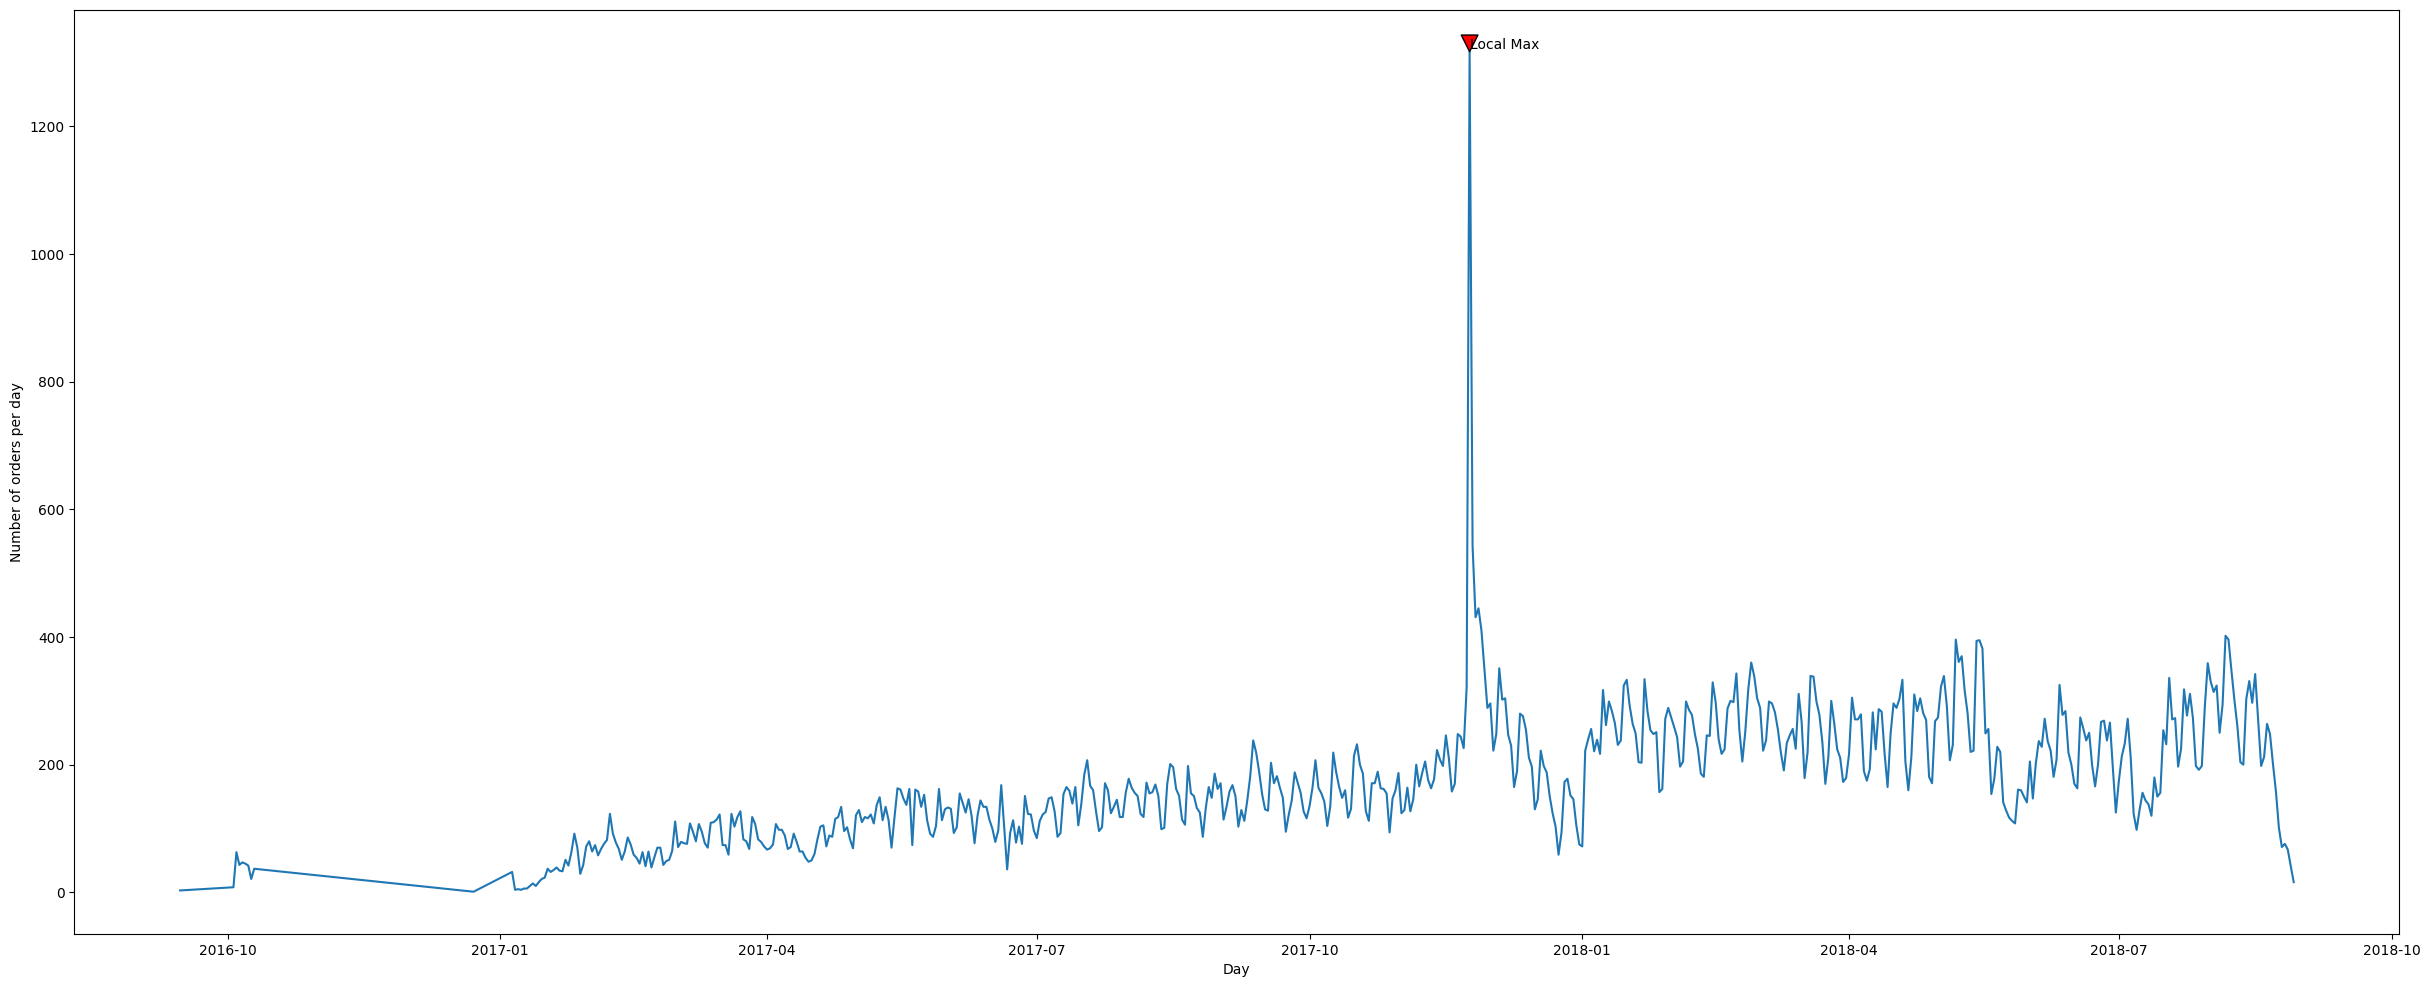

In [154]:
plt.figure(figsize=(30,12))
plt.plot(daily_order)
plt.xlabel("Day")
plt.ylabel("Number of orders per day")


order_max = daily_order[daily_order.order_purchase_timestamp == daily_order.order_purchase_timestamp.max()]
y_max = order_max.order_purchase_timestamp
x_max = order_max.index

plt.annotate('Local Max', xy=(x_max, y_max), xytext=(x_max, y_max+5),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )

plt.show()

,order_purchase_timestamp
order_purchase_timestamp,
2017-11-24,1317


Text(0, 0.5, 'Number of deliveries per day')

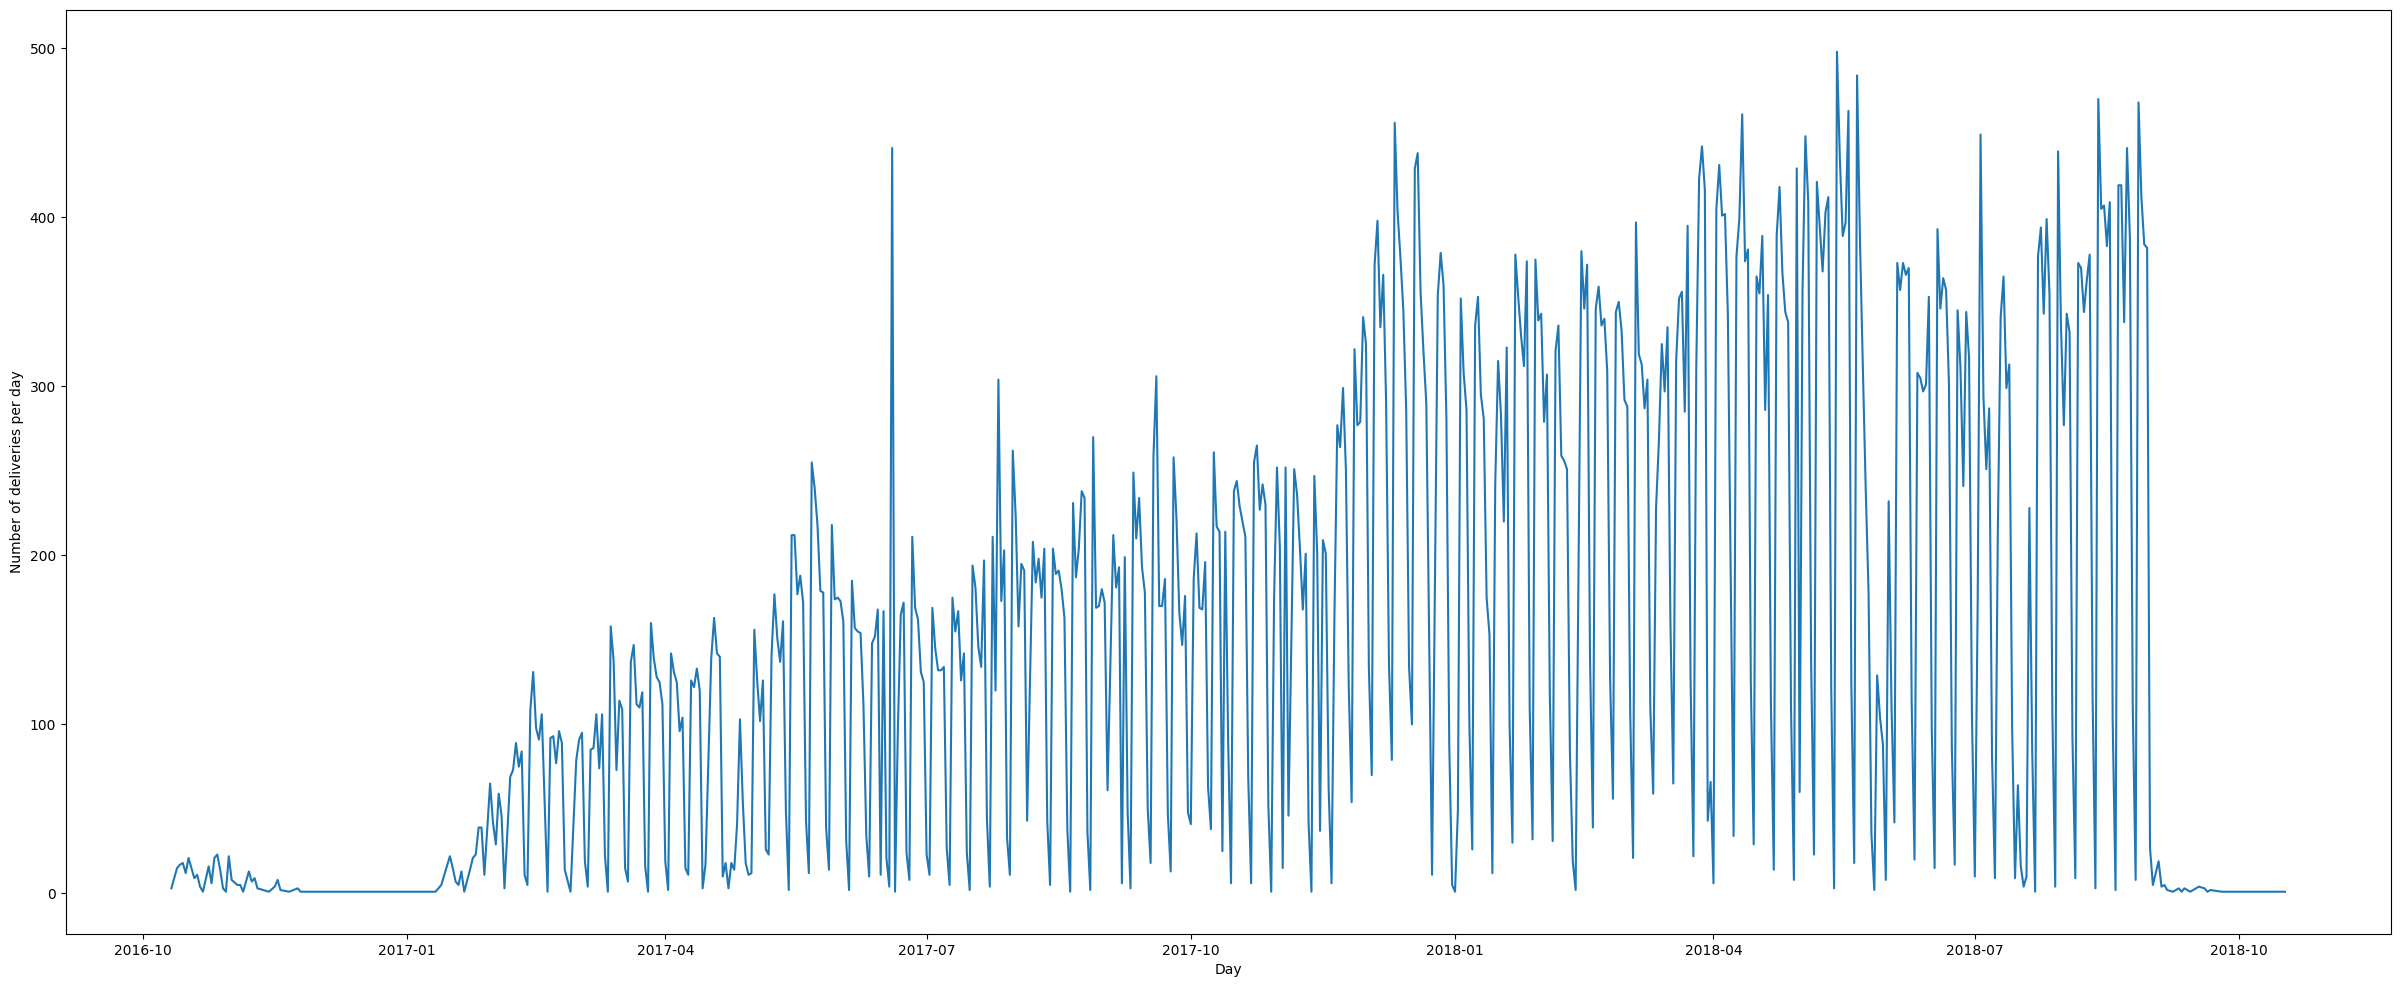

In [136]:
plt.figure(figsize=(30,12))
plt.plot(daily_delivery)
plt.xlabel("Day")
plt.ylabel("Number of deliveries per day")

## Represent data on the map

In [52]:
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [53]:
seller_lat_mean = final_df.geolocation_lat_seller.mean()
seller_len_mean = final_df.geolocation_lng_seller.mean()

seller_map = folium.Map(location=[seller_lat_mean, seller_len_mean], control_scale=True, zoom_start=6)


In [54]:
%matplotlib notebook
final_df.loc[:, "count"] =1
heatmap_data = final_df.head(10000)[['geolocation_lat_seller', 'geolocation_lng_seller', 'count']].groupby(['geolocation_lat_seller', 'geolocation_lng_seller']).sum().reset_index().values.tolist()
gradient = {0.1: 'blue', 0.2: 'lime', 0.3: 'orange', 0.4: 'red', 0.5: 'purple', 0.6: 'black'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(seller_map)
seller_map

## Baseline Model

In [60]:
diff_estim_purchase = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

basic_score = np.mean(diff_estim_purchase - df['wait_time'])
basic_score

11.290435174238587

In [62]:
df.columns

Index(['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date',
       'geolocation_state_customer', 'geolocation_state_seller', 'distance',
       'product_size_cm3', 'product_weight_g', 'wait_time',
       'order_estimated_delivery_date', 'count'],
      dtype='object')

In [61]:
X = df[['distance', 'geolocation_state_customer', 'geolocation_state_seller',
         'product_size_cm3', 'product_weight_g', 'purchase_dow',
         'year', 'purchase_month']]
y = df['wait_time']

X.head()

KeyError: "['purchase_dow', 'year', 'purchase_month'] not in index"